<a href="https://colab.research.google.com/github/luisbeltranc/DeepLearning/blob/main/RNNs_con_TensorFlow_2_y_Keras_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Recurrentes con TensorFlow 2 y Keras

En este ejercicio vamos a realizar una primera experimentación con redes neuronales recurrentes usando TensorFlow 2 y Keras.

In [1]:
# Seleccionar TF 2 (directiva válida sólo en Colab)
# En otros entornos: !pip install tensorflow-gpu==2.0
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
assert tf.__version__ >= "2.0"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Usaremos un DataFrame de pandas para guardar la información de los experimentos
resultados = pd.DataFrame(columns=['modelo', 'num_units', 'num_epochs', 'exactitud (accuracy)'])

## 1. RNN *many-to-one* para clasificación de MNIST

Si tratamos cada imagen MNIST de un alto *m* y ancho *n* como una secuencia de *m* vectores de *n* elementos, podemos emplear una red neuronal para predecir su clase, esto es, el dígito que representa.

Veamos en primer lugar una implementación muy simple usando Keras.


### 1.1. Cargar el conjunto de datos

En primer lugar cargamos el conjunto de datos. En este caso lo haremos usando la librería [`tensorflow_datasets`](https://www.tensorflow.org/datasets/overview), que es una colección de conjuntos de datos listos para ser usados en TensorFlow. El catálogo de conjuntos de conjuntos de datos listos para usar puede consultarse en https://www.tensorflow.org/datasets/catalog/overview

`tensorflow_datasets` cumple con las especificaciones del API [`tf.data.Dataset`](https://www.tensorflow.org/guide/data), la cual permite manejar fácilmente y con alto rendimiento pipelines de entrada complejos. Básicamente, `tf.data.Dataset` representa un conjunto de datos potencialmente muy grande y tiene los mecanismos para preprocesarlo y alimentar las entradas de un modelo lote por lote sin cargar todo el dataset en memoria.



In [2]:
!gsutil cat gs://tfds-data/datasets/mnist/3.0.1/image.image.json

{"encoding_format": "png", "shape": [28, 28, 1]}

In [3]:
# Cargamos mnist desde tensorflow_datasets
dataset, info = tfds.load(name="mnist", as_supervised=True, with_info=True, shuffle_files=False, data_dir="gs://tfds-data/datasets")

In [4]:
# Ver la información sobre el dataset
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [5]:
# Definimos algunas constantes que usaremos en los siguientes modelos

# Longitud de las secuencias: cada imagen tiene 28 filas (alto), cada una será un paso en el tiempo
NUM_STEPS = IMAGE_HEIGHT = info.features['image'].shape[0]   # 28

# Tamaño de cada entrada: cada entrada será una fila de 28 pixeles (ancho)
INPUT_SIZE = IMAGE_WIDTH = info.features['image'].shape[1]   # 28

# Número de unidades que usaaremos en las unidades ocultas de las RNN
NUM_UNITS = 128

# Número de clases de salida: 10 dígitos diferentes
NUM_CLASSES = info.features['label'].num_classes  # 10

In [6]:
dataset

{'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [7]:
# dataset["train"], al igual que dataset["test"], es una instancia de la clase tf.data.Dataset
# No "contiene" los datos, sino que es una clase que permite acceder a ellos.
print(isinstance(dataset["train"], tf.data.Dataset))

True


In [8]:
# Usando element_spec podemos inspeccionar el tipo y dimensiones de los elementos administrados por el tf.data.Dataset
# Dado que cuando hicimos la carga del modelo usamos el argumento "as_supervised=True", los elementos están organizados 
# como un tuple de tensores (features, label), tal cual lo esperará Keras más adelante.
dataset["train"].element_spec

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
# Escribimos una pequeña función en TensorFlow para preprocesar 
# las imágenes dentro de tf.data.dataset
def preprocess_mnist(image, label):
  """Convierte una imagen de: shape=(28, 28, 1), dtype=tf.uint8
  a: shape=(28, 28), dtype=tf.float32
  """

  # Queremos tratar cada imagen como una secuencia de 28 filas de 28 pixels cada una.
  # No necesitamos la última dimensión (1 solo canal de color)
  image = tf.squeeze(image, [-1])

  # Con convert_image_dtype cambiamos de tf.uint8 a valores tf.float32 en el rango de [0,1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  return image, label


In [10]:
dataset["train"].map(preprocess_mnist).shuffle(10000).element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
dataset["train"].map(preprocess_mnist).shuffle(10000).batch(2048).element_spec

(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [12]:
# Preparamos nuestro pipeline
# .map(preprocess_mnist) -- Convierte las imágenes de (28, 28, 1) a (28, 28) tf.float32 en el rango de [0,1]
# .shuffle(10000) -- Cada siguiente ejemplo será tomado aleatoriamente de entre los siguientes 10000 elementos del dataset (que por lo tanto estarán en memoria)
# .batch(32) -- A partir de aquí cada "elemento" del dataset es un batch de 32 ejemplos
# .prefetch(1) -- De manera asíncrona se irá cargando del pipeline el siguiente (1) elemento, para tenerlo listo para la siguiente llamada
mnist_train = dataset["train"].map(preprocess_mnist).shuffle(10000).batch(2048).prefetch(1)

# Paso a paso:
# print('Spec de cada elemento al inicio: ', dataset["train"].element_spec)
# mnist_train = dataset["train"].map(preprocess_mnist)
# print('Spec de cada elemento después de preprocesamiento: ', mnist_train.element_spec)
# mnist_train = mnist_train.shuffle(10000).batch(2048).prefetch(1)
# print('Spec final de cada elemento: ', mnist_train.element_spec)

In [13]:
# Recuperemos el conjunto de test completo y guardémoslo en un arreglo numpy
# Lo usaremos más adelante para calcular las predicciones
for images, labels in dataset["test"].map(preprocess_mnist).batch(10000).take(1):
  test_images = images.numpy()
  test_labels = labels.numpy()

print(test_images.shape, test_labels.shape)

(10000, 28, 28) (10000,)


Label : 2


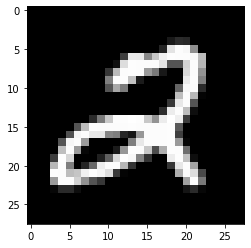

In [14]:
# Mostremos la primera imagen del conjunto de pruebas
IMAGE_INDEX = 0
plt.imshow(test_images[IMAGE_INDEX].astype(np.float32), cmap=plt.get_cmap("gray"))
print("Label :", test_labels[IMAGE_INDEX])

### 1.2. Crear y entrenar una RNN simple con Keras


In [15]:
# Definamos el modelo usando el API Secuencial de Keras (una capa apilada sobre otra)

# model = tf.keras.models.Sequential([
#       keras.layers.SimpleRNN(NUM_UNITS, input_shape=(NUM_STEPS, INPUT_SIZE)),
#       keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# model.summary()


# O usando el API Funcional de Keras (permite grafos más complejos)

inputs  = keras.Input(shape=(NUM_STEPS, INPUT_SIZE))
x = keras.layers.SimpleRNN(NUM_UNITS)(inputs)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               20096     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compilamos y entrenamos el modelo
NUM_EPOCHS = 5
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
history = model.fit(mnist_train, epochs=NUM_EPOCHS)

# Evaluamos y guardamos los resultados
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
# model.evaluate también acepta como entrada un tf.data.Dataset
# loss, accuracy = model.evaluate(mnist_test.map(preprocess_mnist).batch(10000))

resultados = resultados.append({
    'modelo': 'RNN simple, many-to-one -- keras.layers.SimpleRNN',
    'num_units': NUM_UNITS,
    'num_epochs': NUM_EPOCHS,
    'exactitud (accuracy)': accuracy
}, ignore_index=True)
resultados

Epoch 1/5
30/30 [==============================] - 6s 198ms/step - loss: 1.3394 - accuracy: 0.5757
Epoch 2/5
30/30 [==============================] - 2s 63ms/step - loss: 0.6012 - accuracy: 0.8200
Epoch 3/5
30/30 [==============================] - 2s 63ms/step - loss: 0.3669 - accuracy: 0.8941
Epoch 4/5
30/30 [==============================] - 2s 61ms/step - loss: 0.2797 - accuracy: 0.9182
Epoch 5/5
30/30 [==============================] - 2s 63ms/step - loss: 0.2350 - accuracy: 0.9313


,modelo,num_units,num_epochs,exactitud (accuracy)
0,"RNN simple, many-to-one -- keras.layers.SimpleRNN",128,5,0.9342


In [17]:
# Grabemos el modelo y los resultados
model.save('saved_model/rnn_many_to_one')

# Si queremos podemos verificar lo que se ha grabado...
# !ls -alh saved_model
# !ls -alh saved_model/rnn_many_to_many_2_capas

# ...o cargarlo nuevamente a memoria
# new_model = tf.keras.models.load_model('saved_model/rnn_many_to_one')
# new_model.summary()

# Grabemos los resultados
resultados.to_excel('resultados.xlsx', index=False)

# Para leer nuevamente:
# resultados = pd.read_excel('resultados.xlsx')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/rnn_many_to_one/assets


INFO:tensorflow:Assets written to: saved_model/rnn_many_to_one/assets


### 1.3. Implementando nuestra propia celda RNN

Implementaremos una celda RNN respetando las especificaciones de `tf.keras`, de tal modo que podamos seguir usando la funcionalidad de Keras. Para ello creamos una subclase de `tf.keras.Layers.layer` con los siguientes métodos.

#### Build: Tensores para los parámetros del modelo

Creamos los tensores para los datos de entrada y para los parámetros. Inicializamos los pesos $U$ y $W$ con el inicializador *Xavier/Glorot*, esto es, con una distribución aleatoria uniforme en el rango $[-r, +r]$, donde $r = \sqrt{\frac{6}{n_{inputs} + n_{outputs}}}$. Inicializamos los biases $b$ con ceros.

#### Get_initial_state: Iniciando la recurrencia

`Get_initial_state` define el primer estado $\textbf{h}^{(0)}$ con ceros. 

#### Call: Operaciones de la celda RNN

El algoritmo para calcular $\textbf{h}^{(t)}$ a partir de $\textbf{h}^{(t-1)}$ y $\textbf{x}^{(t)}$ es:

$\textbf{a}^{(t)}  = \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}$

$\textbf{h}^{(t)}  = tanh(\textbf{a}^{(t)})$

En el código de abajo las multiplicaciones de matrices se encuentran invertidas en relacion a las ecuaciones porque estamos procesando en lotes las imágenes de entrada y TensorFlow espera recibir los datos con `batch_size` como la primera dimensión (no sería así si pusiésemos `batch_size` como última dimensión).

En cada paso se ejecutará `call`, que nos devuelve las salidas de la celda y los estados que pasan al siguiente paso: $\textbf{h}^{(1)}, ..., \textbf{h}^{(t)}$.

In [18]:
# Simplificado y adaptado de https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/keras/layers/recurrent.py#L1109-L1268
# Para un explicación general sobre la creación de layers personalizados, ver: https://www.tensorflow.org/guide/keras/custom_layers_and_models

class MiCeldaRNN(tf.keras.layers.Layer):
  """Cell class for SimpleRNN.
  Arguments:
    units: Positive integer, dimensionality of the output space.
  Call arguments:
    inputs: A 2D tensor.
    states: List of state tensors corresponding to the previous timestep.
  Returns:
    output: Output tensor.
    next_states: List of state tensors corresponding to the next timestep.
  """

  def __init__(self,
               units,
               **kwargs):
    super(MiCeldaRNN, self).__init__(**kwargs)
    self.units = units
    self.state_size = self.units
    self.output_size = self.units

  # `build` sólo se ejecuta cuando se conoce ya las dimensiones de los inputs
  def build(self, input_shape):
    # U
    self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        name='kernel',
        initializer='glorot_uniform')
    # W
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units),
        name='recurrent_kernel',
        initializer='glorot_uniform')
    # b
    self.bias = self.add_weight(
      shape=(self.units,),
      name='bias',
      initializer='zeros')
    self.built = True

  # `get_initial_state` es propio de los layers de celdas RNN
  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    if inputs is not None:
      batch_size = tf.shape(inputs)[0]
      dtype = inputs.dtype
    return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

  # `call` define las operaciones del layer
  def call(self, inputs, states, training=None):
    b = self.bias
    h_tmenos1 = states[0]
    W = self.recurrent_kernel
    x_t = inputs
    U = self.kernel

    a_t = b + tf.matmul(h_tmenos1, W) + tf.matmul(x_t, U)
    h_t = tf.tanh(a_t)

    # output = tf.tanh(self.bias + tf.matmul(states, self. recurrent_kernel) + tf.matmul(inputs, self.kernel))
    output = h_t
    next_states = [h_t]

    return output, next_states

  # `get_config` es muy fácil de implementar y permite serializar el modelo
  def get_config(self):
    config = {
        'units':
            self.units
    }
    base_config = super(MiCeldaRNN, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [19]:
model = tf.keras.models.Sequential([
      keras.layers.RNN(MiCeldaRNN(NUM_UNITS), input_shape=(NUM_STEPS, INPUT_SIZE)),
      keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 128)               20096     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Habilita la siguiente línea si quieres explorar cómo queda serializada la arquitectura de todo el modelo
model.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'name': 'rnn_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'RNN',
   'config': {'batch_input_shape': (None, 28, 28),
    'cell': {'class_name': 'MiCeldaRNN',
     'config': {'dtype': 'float32',
      'name': 'mi_celda_rnn',
      'trainable': True,
      'units': 128}},
    'dtype': 'float32',
    'go_backwards': False,
    'name': 'rnn',
    'return_sequences': False,
    'return_state': False,
    'stateful': False,
    'time_major': False,
    'trainable': True,
    'unroll': False}},
  {'class_name': 'Dense',
   'config': {'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}}

In [21]:
# Compilamos y entrenamos el modelo
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
history = model.fit(mnist_train, epochs=NUM_EPOCHS)

# Evaluamos y guardamos los resultados
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
model.save('saved_model/rnn_many_to_one_miceldarnn')

resultados = resultados.append({
    'modelo': 'RNN simple, many-to-one -- MiCeldaRNN',
    'num_units': NUM_UNITS,
    'num_epochs': NUM_EPOCHS,
    'exactitud (accuracy)': accuracy
}, ignore_index=True)
resultados.to_excel('resultados.xlsx', index=False)
resultados

Epoch 1/5
30/30 [==============================] - 2s 64ms/step - loss: 1.4699 - accuracy: 0.5294
Epoch 2/5
30/30 [==============================] - 2s 65ms/step - loss: 0.6352 - accuracy: 0.8107
Epoch 3/5
30/30 [==============================] - 2s 66ms/step - loss: 0.4188 - accuracy: 0.8805
Epoch 4/5
30/30 [==============================] - 2s 65ms/step - loss: 0.3185 - accuracy: 0.9107
Epoch 5/5
30/30 [==============================] - 2s 65ms/step - loss: 0.2726 - accuracy: 0.9223
INFO:tensorflow:Assets written to: saved_model/rnn_many_to_one_miceldarnn/assets


INFO:tensorflow:Assets written to: saved_model/rnn_many_to_one_miceldarnn/assets


,modelo,num_units,num_epochs,exactitud (accuracy)
0,"RNN simple, many-to-one -- keras.layers.SimpleRNN",128,5,0.9342
1,"RNN simple, many-to-one -- MiCeldaRNN",128,5,0.9252


## 2. RNN *many-to-many* para clasificación de MNIST

En la primera parte hemos empleado una RNN *many-to-one*, entrenada para clasificar el dígito correspondiente a una imagen MNIST interpretada como una secuencia de filas de pixeles. Ahora experimentaremos con una RNN que intente predecir la clase de la imagen como salida en *cada uno de los pasos* de la RNN.

Para ello, en lugar de calcular las predicciones sólo desde el estado final, las calcularemos desde cada estado. Con ello, las dimensiones de salida serán ahora `[BATCH_SIZE, NUM_STEPS, NUM_CLASSES]`

In [22]:
def tile_labels(images, labels):
  # Los labels vienen en un tensor 1-D de dimensiones: (BATCH_SIZE,)
  # Primero lo convertimos a 2-D con dimensiones: [BATCH_SIZE, 1]
  labels2d = tf.expand_dims(labels, 1)
  # Luego, con tf.tile armamos un "enlosado" de 1x28 piezas de labels2d,
  # quedándonos como resultado un matriz de dimensiones: [BATCH_SIZE, 28]
  labels2d_tiled = tf.tile(labels2d, [1, 28])
  return images, labels2d_tiled

# Siempre es bueno probar que nuestra funciones hagan lo que esperamos
def test_tile_labels():
   input_labels = tf.constant([3, 2, 7, 5])
   expected_result = [ [x] * 28 for x in input_labels ]
   images, tiled_labels = tile_labels(None, input_labels)
   # assert(np.array_equal(tiled_labels, expected_result))
   print('Tensor de entrada :', input_labels)
   print('\n...se transforma en...\n')
   print('Tensor de salida :', tiled_labels)
test_tile_labels()

Tensor de entrada : tf.Tensor([3 2 7 5], shape=(4,), dtype=int32)

...se transforma en...

Tensor de salida : tf.Tensor(
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]], shape=(4, 28), dtype=int32)


In [23]:
# Añadimos return_sequences=True para emitir salidas en cada paso
model = tf.keras.models.Sequential([
      keras.layers.SimpleRNN(NUM_UNITS, input_shape=(NUM_STEPS, INPUT_SIZE), return_sequences=True),
      keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Observa que las dimensiones de salida han cambiado, pero el número de parámetros no
# Asegúrate que entiendes por qué
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 28, 128)           20096     
_________________________________________________________________
dense_2 (Dense)              (None, 28, 10)            1290      
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compilamos y entrenamos el modelo
NUM_EPOCHS = 5
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
history = model.fit(mnist_train.map(tile_labels), epochs=NUM_EPOCHS)

# Calculamos la exactitud manualmente a partir de las predicciones
from sklearn.metrics import accuracy_score
test_pred_proba = model.predict_proba(test_images)  # (10000, 28, 10) Probabilidades para cada clase para cada paso de la secuencia
test_pred = np.argmax(test_pred_proba, axis=-1)  # (10000, 28) Clase predecida para cada paso de la secuencia 
test_pred_flat = test_pred.reshape([-1])  # (280000,) test_pred "flattened" 
test_labels_tiled = np.tile(np.expand_dims(test_labels, axis=1), [1,28])  # (10000, 28) Clase "target" para cada paso de la secuencia
test_labels_tiled_flat = test_labels_tiled.reshape([-1])  # (280000,) test_labels_tiled "flattened" 

test_acc_general = accuracy_score(test_labels_tiled_flat, test_pred_flat)  # Acc considerando cada paso de la secuencia
test_acc_last = accuracy_score(test_labels, test_pred[:,-1])  # Acc considerando sólo la predicción final de la secuencia
print('Exactitud general en las predicciones :', test_acc_general)
print('Exactitud en la predicción del último paso :', test_acc_last)

# Comparamos con la exactitud que calcula Keras
loss, accuracy = model.evaluate(test_images, test_labels_tiled, verbose=0)
model.save('saved_model/rnn_many_to_many')
print('Exactitud calculada por Keras :', accuracy)

# Juntamos los resultados
resultados = resultados.append({
    'modelo': 'RNN simple, many-to-many -- BasicRNNCell',
    'num_units': NUM_UNITS,
    'num_epochs': NUM_EPOCHS,
    'exactitud (accuracy)': test_acc_general,
    'exactitud (accuracy) en último paso': test_acc_last
}, ignore_index=True)
resultados.to_excel('resultados.xlsx', index=False)
resultados

Epoch 1/5
30/30 [==============================] - 2s 61ms/step - loss: 2.0819 - accuracy: 0.2393
Epoch 2/5
30/30 [==============================] - 2s 62ms/step - loss: 1.7295 - accuracy: 0.3732
Epoch 3/5
30/30 [==============================] - 2s 66ms/step - loss: 1.5175 - accuracy: 0.4538
Epoch 4/5
30/30 [==============================] - 2s 61ms/step - loss: 1.3669 - accuracy: 0.5165
Epoch 5/5
30/30 [==============================] - 2s 62ms/step - loss: 1.2531 - accuracy: 0.5629
Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.


Exactitud general en las predicciones : 0.5841392857142857
Exactitud en la predicción del último paso : 0.8047
INFO:tensorflow:Assets written to: saved_model/rnn_many_to_many/assets


INFO:tensorflow:Assets written to: saved_model/rnn_many_to_many/assets


Exactitud calculada por Keras : 0.5841392874717712


,modelo,num_units,num_epochs,exactitud (accuracy),exactitud (accuracy) en último paso
0,"RNN simple, many-to-one -- keras.layers.SimpleRNN",128,5,0.934200,NaN
1,"RNN simple, many-to-one -- MiCeldaRNN",128,5,0.925200,NaN
2,"RNN simple, many-to-many -- BasicRNNCell",128,5,0.584139,0.8047


Visualicemos las predicciones para cada uno de los pasos en una imagen cualquiera del conjunto de pruebas:

In [25]:
def visualize_preds(image, test_pred_proba, dataset='mnist'):

  fashion_mnist_label_names = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

  # Para facilitar esta visualización convertimos los pixels en caracteres ASCII
  ascii_grayscale = "B@%#*+=-:. "
  ascii_image = [[ascii_grayscale[int(round(pixel * (len(ascii_grayscale) - 1)))] for pixel in row] for row in image]

  print("{:31}{:15}{:10}".format(
    "Filas de la imagen", 
    "Predicción",
    "Probabilidad"
      ))
  for image_row, proba in zip(ascii_image, test_pred_proba):
    pred = np.argmax(proba)
    proba = np.max(proba)
    if dataset == 'fashion_mnist':
      label = ' ({})'.format(fashion_mnist_label_names[int(pred)])
    else:
      label = ''
    print("{}{:9d}{:18.7f}{}".format(
      ''.join(image_row), 
      pred,
      proba,
      label
      ))
  print()

# Mostremos algunas imágenes aleatorias del conjunto de pruebas
NUM_SAMPLES = 2
for IMAGE_INDEX in np.random.randint(test_images.shape[0], size=NUM_SAMPLES):
  print("Imagen #", IMAGE_INDEX)
  print("Label :", test_labels[IMAGE_INDEX])
  visualize_preds(test_images[IMAGE_INDEX], test_pred_proba[IMAGE_INDEX])


Imagen # 2276
Label : 3
Filas de la imagen             Predicción     Probabilidad
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1064847
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1113526
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1177803
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1261280
BBBBBBBBBB#==.  -@BBBBBBBBBB        8         0.1829318
BBBBBBBBB#       -@BBBBBBBBB        8         0.2684815
BBBBBBBBB*        =BBBBBBBBB        2         0.2334992
BBBBBBBBB@+##B@:  .@BBBBBBBB        2         0.3051448
BBBBBBBBBBBBBBB@.  %BBBBBBBB        3         0.3747651
BBBBBBBBBBBBBBB#  .@BBBBBBBB        3         0.4343815
BBBBBBBBBBBBBB%:  +BBBBBBBBB        3         0.4523971
BBBBBBBBBBBB@=    #BBBBBBBBB        3         0.4614711
BBBBBBBBBBBB+     .*BBBBBBBB        3         0.5019631
BBBBBBBBBBB@.       *BBBBBBB        3         0.5752100
BBBBBBBBBBBB%***-:  .@BBBBBB        3         0.6752193
BBBBBBBBBBBBBBBBB*   =BBBBBB        3         0.7153963
BBBBBBBBBBBBBBBBBB=  

## 3. Añadiendo profundidad y bidireccionalidad

Es muy fácil apilar varias capas RNN una sobre otra. En esos casos, independientemente si se emitirá una sola salida al final (como en la red many-to-one de arriba) o una salida en cada paso (como en la red many-to-many), *todas* las capas anteriores a la última capa RNN deben usar ´return_sequences = true´. ¿Por qué?

Por otro lado, para añadir bidireccionalidad, es suficiente con envolver *(wrap)* la capa RNN con la capa `Bidirectional`, p.ej.:

```python
  keras.layers.Bidirectional(SimpleRNN(5)),
```

¿Qué esperarías que fuera mejor para mejorar la exactitud en esta particular red many-to-many? ¿Una segunda capa de profundidad? ¿O añadir bidireccionalidad? ¿Por qué?

Prepara dos modelos many-to-many con el dataset `fashion_mnist`: uno con 3 capas recurrentes (profundidad) y uno con una sola capa bidireccional. Entrena los modelos por 20 épocas y visualiza las predicciones para cada paso, usando las funciones definidas en este notebook. Comentar los resultados obtenidos.

***Respuesta:***
Esperaría que sea mejor la exactitud añadiendo bidireccionalidad. Por que esta ya habría visto toda la imagen, no sólo las líneas pasadas y el presente sino las líneas que vienen hasta el final desde un principio.

In [26]:
inputs  = keras.Input(shape=(NUM_STEPS, INPUT_SIZE))
x = keras.layers.SimpleRNN(NUM_UNITS,return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(NUM_UNITS,return_sequences=True)(x)
x = keras.layers.SimpleRNN(NUM_UNITS,return_sequences=True)(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 28, 128)           20096     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 28, 128)           32896     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 28, 128)           32896     
_________________________________________________________________
dense_3 (Dense)              (None, 28, 10)            1290      
Total params: 87,178
Trainable params: 87,178
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compilamos y entrenamos el modelo
NUM_EPOCHS = 20
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
history = model.fit(mnist_train.map(tile_labels), epochs=NUM_EPOCHS)

# Comparamos con la exactitud que calcula Keras
loss, accuracy = model.evaluate(test_images, test_labels_tiled, verbose=0)
model.save('saved_model/rnn_many_to_many')
print('Exactitud calculada por Keras :', accuracy)

# Juntamos los resultados
resultados = resultados.append({
    'modelo': 'RNN simple, many-to-many -- 3CapasProfundidad',
    'num_units': NUM_UNITS,
    'num_epochs': NUM_EPOCHS,
    'exactitud (accuracy)': accuracy,
    #'exactitud (accuracy) en último paso': test_acc_last
}, ignore_index=True)
resultados.to_excel('resultados.xlsx', index=False)
resultados

Epoch 1/20
30/30 [==============================] - 3s 94ms/step - loss: 1.8605 - accuracy: 0.3421
Epoch 2/20
30/30 [==============================] - 3s 95ms/step - loss: 1.2620 - accuracy: 0.5581
Epoch 3/20
30/30 [==============================] - 3s 92ms/step - loss: 1.0492 - accuracy: 0.6345
Epoch 4/20
30/30 [==============================] - 3s 92ms/step - loss: 0.9403 - accuracy: 0.6724
Epoch 5/20
30/30 [==============================] - 3s 92ms/step - loss: 0.8819 - accuracy: 0.6911
Epoch 6/20
30/30 [==============================] - 3s 93ms/step - loss: 0.8509 - accuracy: 0.6997
Epoch 7/20
30/30 [==============================] - 3s 93ms/step - loss: 0.8191 - accuracy: 0.7109
Epoch 8/20
30/30 [==============================] - 3s 92ms/step - loss: 0.7982 - accuracy: 0.7163
Epoch 9/20
30/30 [==============================] - 3s 96ms/step - loss: 0.7799 - accuracy: 0.7227
Epoch 10/20
30/30 [==============================] - 3s 95ms/step - loss: 0.7653 - accuracy: 0.7261
Epoch 11/

INFO:tensorflow:Assets written to: saved_model/rnn_many_to_many/assets


Exactitud calculada por Keras : 0.7496857047080994


,modelo,num_units,num_epochs,exactitud (accuracy),exactitud (accuracy) en último paso
0,"RNN simple, many-to-one -- keras.layers.SimpleRNN",128,5,0.934200,NaN
1,"RNN simple, many-to-one -- MiCeldaRNN",128,5,0.925200,NaN
2,"RNN simple, many-to-many -- BasicRNNCell",128,5,0.584139,0.8047
3,"RNN simple, many-to-many -- 3CapasProfundidad",128,20,0.749686,NaN


In [28]:
# Mostremos algunas imágenes aleatorias del conjunto de pruebas
NUM_SAMPLES = 2
for IMAGE_INDEX in np.random.randint(test_images.shape[0], size=NUM_SAMPLES):
  print("Imagen #", IMAGE_INDEX)
  print("Label :", test_labels[IMAGE_INDEX])
  visualize_preds(test_images[IMAGE_INDEX], test_pred_proba[IMAGE_INDEX])

Imagen # 4635
Label : 9
Filas de la imagen             Predicción     Probabilidad
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1064847
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1113526
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1177803
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1261280
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1405393
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        7         0.1722268
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        7         0.2425622
BBBBBBBBBBBBBB#.  @BBBBBBBBB        7         0.2691915
BBBBBBBBBBBBB* -#.=BBBBBBBBB        1         0.3534781
BBBBBBBBBBBB+ -BB=:BBBBBBBBB        7         0.3832090
BBBBBBBBBBB+ :@BB*:BBBBBBBBB        7         0.4343766
BBBBBBBBBB# :@BB@+:BBBBBBBBB        7         0.4327148
BBBBBBBBB@:.@BB+  :BBBBBBBBB        7         0.3092745
BBBBBBBBB# +B%.   :BBBBBBBBB        9         0.3519238
BBBBBBBBB:.%* .   :BBBBBBBBB        9         0.4548327
BBBBBBBB% .. -#.  =BBBBBBBBB        9         0.5128206
BBBBBBBBB+ -%B- *-%BB

In [29]:
inputs  = keras.Input(shape=(NUM_STEPS, INPUT_SIZE))
x = keras.layers.Bidirectional(keras.layers.SimpleRNN(NUM_UNITS,return_sequences=True))(inputs)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

  #keras.layers.Bidirectional(SimpleRNN(5)),

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 28, 256)           40192     
_________________________________________________________________
dense_4 (Dense)              (None, 28, 10)            2570      
Total params: 42,762
Trainable params: 42,762
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compilamos y entrenamos el modelo
NUM_EPOCHS = 20
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
history = model.fit(mnist_train.map(tile_labels), epochs=NUM_EPOCHS)

# Comparamos con la exactitud que calcula Keras
loss, accuracy = model.evaluate(test_images, test_labels_tiled, verbose=0)
model.save('saved_model/rnn_many_to_many')
print('Exactitud calculada por Keras :', accuracy)

# Juntamos los resultados
resultados = resultados.append({
    'modelo': 'RNN simple, many-to-many -- 1CapaBidireccional',
    'num_units': NUM_UNITS,
    'num_epochs': NUM_EPOCHS,
    'exactitud (accuracy)': accuracy,
    #'exactitud (accuracy) en último paso': test_acc_last
}, ignore_index=True)
resultados.to_excel('resultados.xlsx', index=False)
resultados

Epoch 1/20
30/30 [==============================] - 2s 80ms/step - loss: 1.9001 - accuracy: 0.3307
Epoch 2/20
30/30 [==============================] - 2s 77ms/step - loss: 1.3591 - accuracy: 0.5355
Epoch 3/20
30/30 [==============================] - 2s 75ms/step - loss: 0.9863 - accuracy: 0.6837
Epoch 4/20
30/30 [==============================] - 2s 78ms/step - loss: 0.7311 - accuracy: 0.7816
Epoch 5/20
30/30 [==============================] - 2s 80ms/step - loss: 0.5830 - accuracy: 0.8304
Epoch 6/20
30/30 [==============================] - 2s 75ms/step - loss: 0.4992 - accuracy: 0.8567
Epoch 7/20
30/30 [==============================] - 2s 79ms/step - loss: 0.4273 - accuracy: 0.8793
Epoch 8/20
30/30 [==============================] - 2s 77ms/step - loss: 0.3802 - accuracy: 0.8930
Epoch 9/20
30/30 [==============================] - 2s 81ms/step - loss: 0.3456 - accuracy: 0.9033
Epoch 10/20
30/30 [==============================] - 2s 78ms/step - loss: 0.3161 - accuracy: 0.9116
Epoch 11/

INFO:tensorflow:Assets written to: saved_model/rnn_many_to_many/assets


Exactitud calculada por Keras : 0.9500499963760376


,modelo,num_units,num_epochs,exactitud (accuracy),exactitud (accuracy) en último paso
0,"RNN simple, many-to-one -- keras.layers.SimpleRNN",128,5,0.934200,NaN
1,"RNN simple, many-to-one -- MiCeldaRNN",128,5,0.925200,NaN
2,"RNN simple, many-to-many -- BasicRNNCell",128,5,0.584139,0.8047
3,"RNN simple, many-to-many -- 3CapasProfundidad",128,20,0.749686,NaN
4,"RNN simple, many-to-many -- 1CapaBidireccional",128,20,0.950050,NaN


In [31]:
# Mostremos algunas imágenes aleatorias del conjunto de pruebas
NUM_SAMPLES = 2
for IMAGE_INDEX in np.random.randint(test_images.shape[0], size=NUM_SAMPLES):
  print("Imagen #", IMAGE_INDEX)
  print("Label :", test_labels[IMAGE_INDEX])
  visualize_preds(test_images[IMAGE_INDEX], test_pred_proba[IMAGE_INDEX])

Imagen # 274
Label : 1
Filas de la imagen             Predicción     Probabilidad
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1064847
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1113526
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1177803
BBBBBBBBBBBBBBBBBBBBBBBBBBBB        1         0.1261280
BBBBBBBBBBBBBBBBBBBBBB-@BBBB        1         0.1258477
BBBBBBBBBBBBBBBBBBBBB= @BBBB        5         0.1609206
BBBBBBBBBBBBBBBBBBB#- .@BBBB        0         0.2578599
BBBBBBBBBBBBBBBBBB%. -%BBBBB        4         0.3137773
BBBBBBBBBBBBBBBBB%  -%BBBBBB        4         0.4222594
BBBBBBBBBBBBBBBB=. -BBBBBBBB        4         0.4589259
BBBBBBBBBBBBBBB#. .#BBBBBBBB        4         0.4237268
BBBBBBBBBBBBBB%.  %BBBBBBBBB        4         0.3631960
BBBBBBBBBBBBB%   -BBBBBBBBBB        1         0.4970810
BBBBBBBBBBBB@.  *@BBBBBBBBBB        1         0.7018203
BBBBBBBBBBBB=  -@BBBBBBBBBBB        1         0.8737467
BBBBBBBBBBB=  -@BBBBBBBBBBBB        1         0.9140400
BBBBBBBBBB%.  BBBBBBBB

Se verifica que para este ejemplo el considerar la red bidireccional dio mejores resultados que adicionando profundidad en la capa.